<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/weights/DUDL_weights_codeChallenge_weightstd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

# Import and process the data

In [2]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

In [3]:
# Convert to tensor
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [4]:
def create_the_MNIST_net():
    """
    MODEL_PERFORM_MNIST_NO7 | MODEL_PERFORM_TIME | WEIGHTS_DEMO_INITS | WEIGHTS_VARIANCE_INITS
    """
    class mnist_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)
        
    # Create the model instance
    net = mnist_net()

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, loss_func, optimizer

# Create a function that trains the model

In [5]:
def train_the_model(net, loss_func, optimizer):
  """
  WEIGHTS_DEMO_INITS | WEIGHTS_VARIANCE_INITS
  """
  num_epochs = 10
  

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      # pred_labels = torch.argmax(net(X), axis=1)
      pred_labels = net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((torch.argmax(pred_labels, axis=1)) == y).float()))

  # Function output
  return train_acc, test_acc, losses, net

# Start the experiment!

In [6]:
# Range of Standard Deviations to use
stdevs = np.logspace(start=np.log10(0.001), stop=np.log10(10), num=25)

# Number of histogram bins for plotting distributions
n_hist_bins = 80

# Initialize results output matrix
acc_results = np.zeros(len(stdevs))
histo_data  = np.zeros((len(stdevs), 2, n_hist_bins))

# Start the timer!
start_time = time.process_time()

# Start the experiment
for stdev_idx, stdev_i in enumerate(stdevs):

    # Create the network
    net, loss_func, optimizer = create_the_MNIST_net()

    # Set all parameters according to the standard deviation
    for p in net.named_parameters():
        p[1].data = torch.randn_like(p[1].data) * stdev_i
    
    # Train the model
    train_acc, test_acc, losses, net = train_the_model(net, loss_func, optimizer)

    # Get test accuracy on final 3 runs (averaging increases stability)
    acc_results[stdev_idx] = np.mean(test_acc[-3:])

    # Collect all parameters into one vector and compute its histogram
    temp_params = np.array([])
    for p in net.named_parameters():
        temp_params = np.concatenate((temp_params, p[1].data.numpy().flatten()), axis=0)
    
    # Compute their histogram
    y, x = np.histogram(temp_params, n_hist_bins)
    histo_data[stdev_idx, 0, :] = (x[1:] + x[:-1]) / 2
    histo_data[stdev_idx, 1, :] = y

    # Status report
    time_elapsed = time.process_time() - start_time
    print(f'Finished {stdev_idx + 1}/{len(stdevs)} after {time_elapsed:3.0f}s. Model accuracy: {acc_results[stdev_idx]:.2f}%')

Finished 1/25 after  14s. Model accuracy: 93.77%
Finished 2/25 after  28s. Model accuracy: 93.27%
Finished 3/25 after  42s. Model accuracy: 93.35%
Finished 4/25 after  55s. Model accuracy: 93.97%
Finished 5/25 after  69s. Model accuracy: 93.80%
Finished 6/25 after  83s. Model accuracy: 94.55%
Finished 7/25 after  97s. Model accuracy: 94.75%
Finished 8/25 after 110s. Model accuracy: 94.78%
Finished 9/25 after 124s. Model accuracy: 94.78%
Finished 10/25 after 136s. Model accuracy: 94.20%
Finished 11/25 after 150s. Model accuracy: 94.08%
Finished 12/25 after 162s. Model accuracy: 94.78%
Finished 13/25 after 175s. Model accuracy: 94.43%
Finished 14/25 after 188s. Model accuracy: 95.32%
Finished 15/25 after 201s. Model accuracy: 94.62%
Finished 16/25 after 215s. Model accuracy: 94.97%
Finished 17/25 after 228s. Model accuracy: 93.53%
Finished 18/25 after 240s. Model accuracy: 91.13%
Finished 19/25 after 253s. Model accuracy: 51.97%
Finished 20/25 after 267s. Model accuracy: 19.38%
Finished 

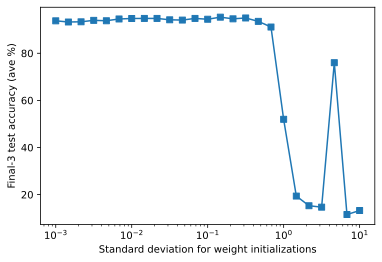

In [11]:
# Show the results
plt.plot(stdevs, acc_results, 's-')
plt.xlabel('Standard deviation for weight initializations')
plt.ylabel('Final-3 test accuracy (ave %)')
plt.xscale('log')
# plt.ylim([80, 100])
plt.show()

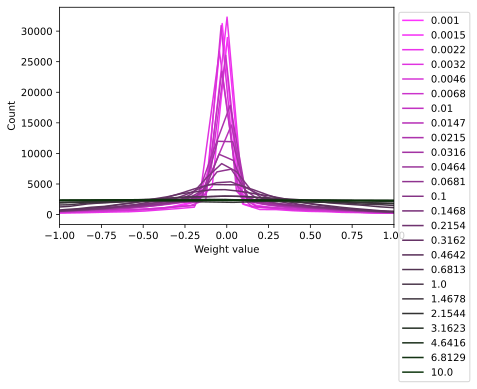

In [10]:
# Show the weights distributions

for i in range(len(stdevs)):
    plt.plot(histo_data[i, 0, :], histo_data[i, 1, :], color=[1 - i / len(stdevs), 0.2, 1 - i / len(stdevs)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(stdevs, 4), bbox_to_anchor=(1, 1), loc='upper left')
plt.xlim([-1, 1])
plt.show()

# Additional explorations

In [9]:
# 1) Are you sure we calculated the standard deviations correctly? Immediately after the code that initializes the weights,
#    write some more code that gets all of the weights (across all layers), compute the standard deviation, and then print
#    out the desired and actual standard deviations. Note that they won't correspond exactly, due to sampling variability.
#    Also note that because this is just a sanity check, you don't actually need to train the model; just verify that the
#    weights have been correctly calculated.
# 
# 2) Here we used torch.randn to assign the weights. randn creates Gaussian random numbers with a mean of 0, and thus
#    the weights were initialized with both positive and negative values. Try running the experiment again using 
#    torch.rand, which creates uniformly distributed numbers between 0 and 1. 
#    NOTE: Specifying the standard deviation of a uniform distribution is slightly more involved compared to a normal
#    distribution. See https://math.stackexchange.com/a/140081 for instructions.
# 